# <center> <img src="../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> **Big Data** </center>
---
### <center> **Autumn 2025** </center>
---
### <center> **Examples on Structured Streaming (files)** </center>
---
**Profesor**: Pablo Camarillo Ramirez

# Create SparkSession

In [2]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on Structured Streaming") \
    .master("spark://bb6818473482:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")
# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/08 01:18:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Create a data stream from a local socket

### Install netcat utility

In [2]:
!apt-get update
!apt-get install -y netcat

Get:1 http://archive.ubuntu.com/ubuntu jammy InRelease [270 kB]                
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [266 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy/main amd64 Packages [1,792 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy/restricted amd64 Packages [164 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [17.5 MB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,425 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [69.1 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [5,922 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [71.0 kB]
Get:13 http://security.ubu

In [2]:
!apt-get update
!apt-get install -y netcat

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
netcat is already the newest version (1.218-4ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


### Connect Spark to the socket

In [3]:
# Create the remote connection
lines = spark.readStream \
            .format("socket") \
            .option("host", "localhost") \
            .option("port", 9999) \
            .load()
# Perform some transformations to the input data (word counter)
from pyspark.sql.functions import explode, split
words = lines.select(explode(split(lines.value, " ")).alias("word"))
word_count = words.groupBy("word").count()

# Send transformed data to the Sink
query = word_count.writeStream \
            .outputMode("complete") \
            .format("console") \
            .start()
query.awaitTermination(20)


-------------------------------------------
Batch: 0
-------------------------------------------
+----+-----+
|word|count|
+----+-----+
+----+-----+



[Stage 3:===================================>                       (3 + 2) / 5]

False

-------------------------------------------
Batch: 1
-------------------------------------------
+----+-----+
|word|count|
+----+-----+
|hola|    1|
+----+-----+



-------------------------------------------
Batch: 2
-------------------------------------------
+-----+-----+
| word|count|
+-----+-----+
|hello|    1|
| hola|    1|
+-----+-----+

-------------------------------------------
Batch: 3
-------------------------------------------
+-----+-----+
| word|count|
+-----+-----+
|hello|    1|
| hola|    2|
+-----+-----+



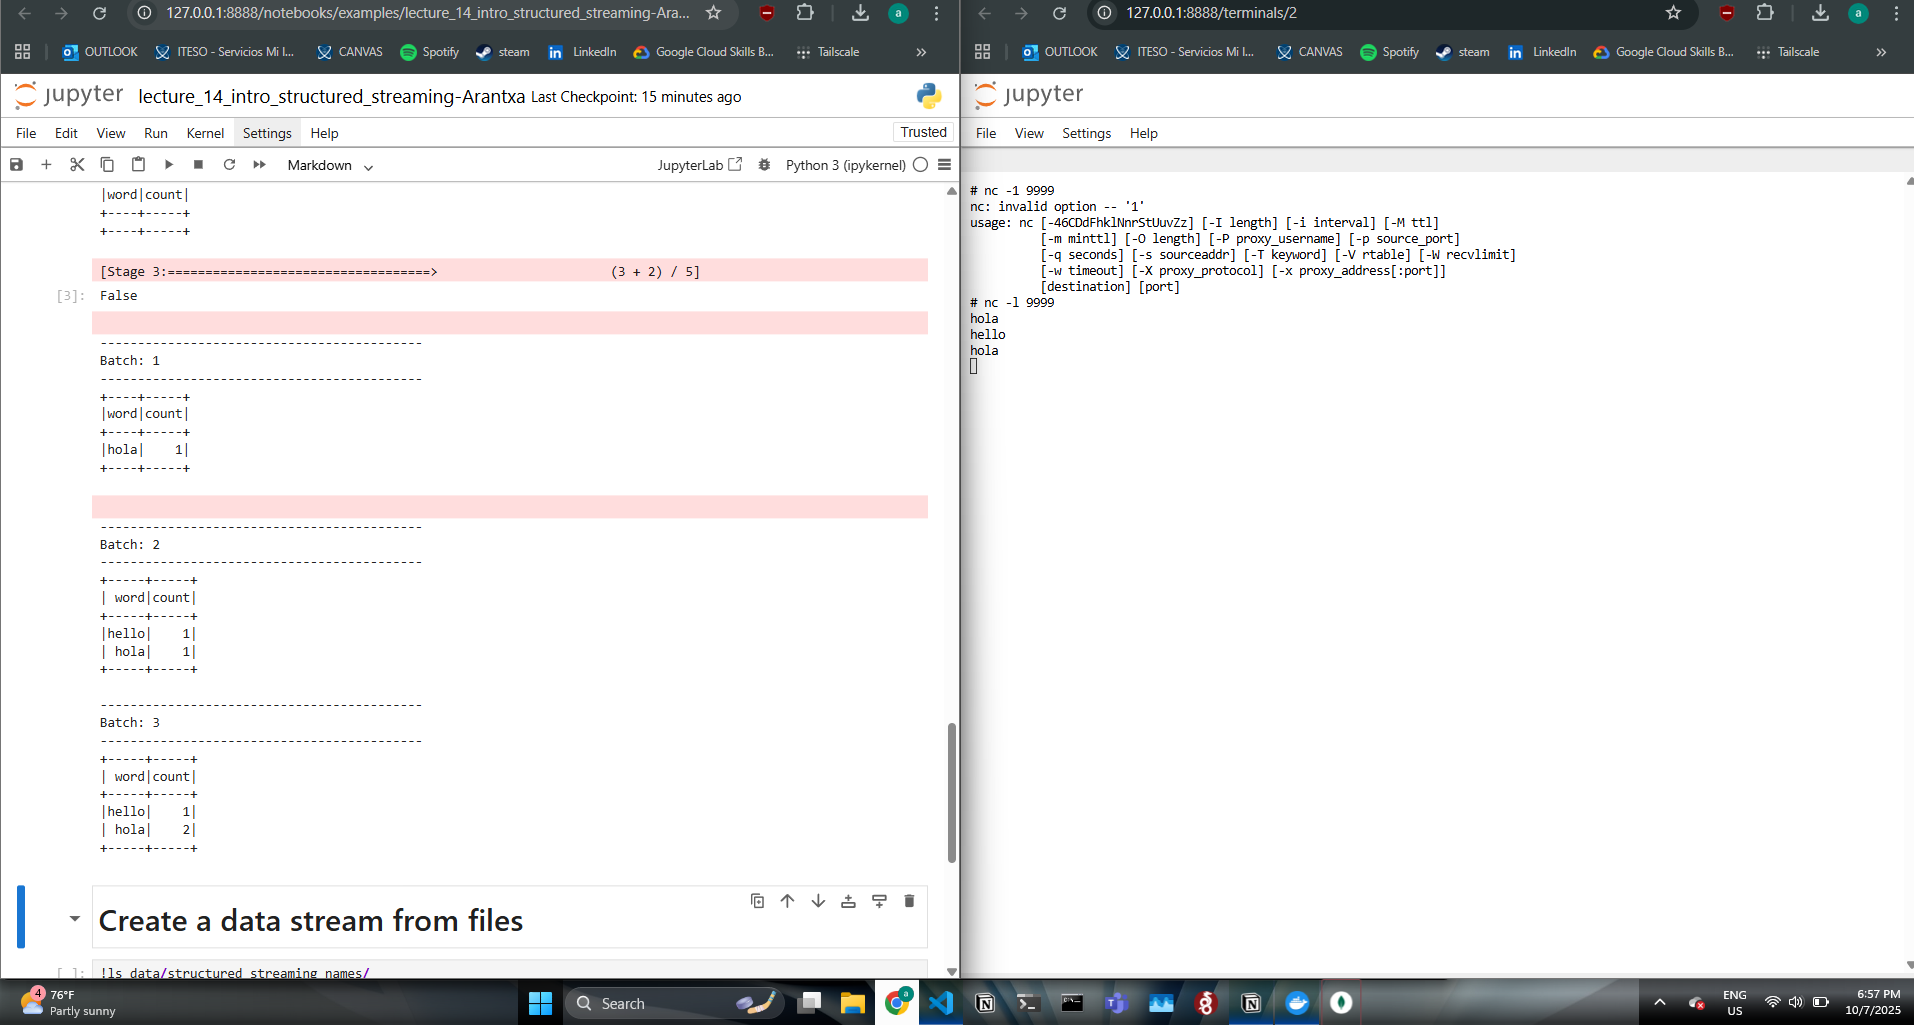

# Create a data stream from files

In [4]:
!ls /spark/data/structured_streaming_names/
!pwd

ls: cannot access '/spark/data/structured_streaming_names/': No such file or directory
/opt/spark/work-dir/examples


In [ ]:
from pcamarillor.spark_utils import SparkUtils

names_schema = SparkUtils.generate_schema([("name", "string"), ("gpa", "float")])

names_df = spark.readStream \
            .schema(names_schema) \
            .format("json") \
            .load("/opt/spark/work-dir/data/structured_streaming_names/")

query = names_df.writeStream \
            .outputMode("append") \
            .format("console") \
            .start()

query.awaitTermination()

-------------------------------------------
Batch: 0
-------------------------------------------
+----+---+
|name|gpa|
+----+---+
+----+---+



-------------------------------------------
Batch: 1
-------------------------------------------
+-------+----+
|   name| gpa|
+-------+----+
|Arantxa|50.0|
+-------+----+



In [ ]:
query.stop()
sc.stop()